# Scenario C - Peak Number Variation

In this scenario the number of peaks in a generated dataset is varied in from low to high (e.g. 2-6), 
the rest of the parameters is kept constant (noise level = 1%). The number of peaks expected by the probabilistic model is varied between the low and high peak number.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_2x2'
file_basename = out_path + '/scenario_peaks'
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf = {}
    
# scenario name
conf['scenario'] = 'peak variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'preload'

# dataset directory (needed for 'preload' data mode)
conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
conf

{'scenario': 'peak variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'preload',
 'dataset_dir': './input_datasets',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lpeakdata = []

# number of spectra per peak number
nsets  = 1

# number of peaks in the spectrum
peak_numbers = [2,3]

# total number of datasets
tsets = nsets * len(peak_numbers)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for pn in peak_numbers:
        for i in range(nsets):
            df, peaks, df_peakinfo = dg.data_generator(xvalues=xval, nsamples=15, npeaks=pn)
            ldata.append(df)
            lpeaks.append(peaks)
            lpeakdata.append(df_peakinfo)
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
        lpeakdata[i].to_csv(out_path + '/peakdata_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, lpeakdata = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, lpeakdata = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, lpeakdata = dg.data_load(tsets, out_path)

In [7]:
print("total number of peak numbers            : {0}".format(len(peak_numbers)))
print("total number of spectra per peak number : {0}".format(nsets))
print("total number of datasets per model      : {0}".format(tsets))
print("total number of inference runs          : {0}".format(nsets*len(peak_numbers)**2))

total number of peak numbers            : 2
total number of spectra per peak number : 1
total number of datasets per model      : 2
total number of inference runs          : 4


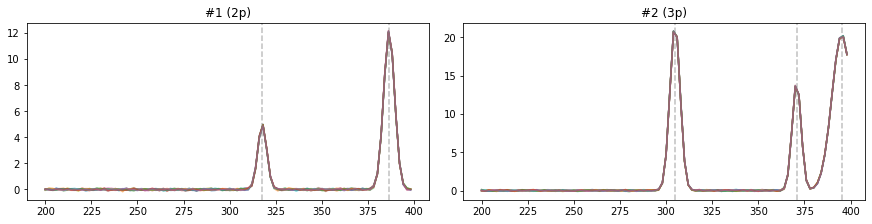

In [8]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                                                        savefig='yes', fname=file_basename, scenario='peaks')

# Initialize models and run inference

In [9]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [10]:
# initialize models and run inference
models = []
traces = []

# list of tuples with (model,peak) combination
lmodpeak = []

# actual run number
run = 1

# total number of inference runs
truns = nsets * len(peak_numbers)**2

for pn in peak_numbers:
    if conf['model_mode'] == 'train':
        # for each model (from low-high peak number) run inference on all spectra
        print("running {0}-peak model".format(pn))
    
    for i in range(len(ldata)):
        if conf['peak_info'] == 'yes':
            # Get the peak numbers from the list. If the actual peak number in the spectrum is 
            # lower than what the model is expecting, then expand the list to the expected size,
            # duplicating the existing peak mu values, else truncate the list (taking the peaks
            # with the highest amplitude).
            plist = sorted(lpeaks[i])
            if len(plist) < pn:
                pl = sorted(np.resize(plist, (1,pn)).flatten())
            else:
                # sort peak info dataframe on amplitude value 
                l1 = lpeakdata[i].sort_values('amp', ascending=False)
                # truncate list to expected peak number
                pl = l1['mu'].values[:pn]
                
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=pn, 
                                      mu_peaks=pl, pmodel=conf['prior_model'])
        else:
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=pn,
                                      pmodel=conf['prior_model'])      
        models.append(model_g)

        with model_g:
            if conf['model_mode'] == 'train':
                print("({2}/{3}) running inference on dataset #{0}/{1} [{4}-peak model:{5}-peak spectrum]"
                      .format(i+1,len(ldata),run,truns,pn,len(plist)))
                lmodpeak += [(pn,len(plist))]
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (run), trace_g)
            else:
                # load traces from disk
                print("loading dataset #{0}/{1}".format(run,truns))
                trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (run))
                traces.append(trace_g)
            run += 1

running 2-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1/4) running inference on dataset #1/2 [2-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 411.44draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2/4) running inference on dataset #2/2 [2-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 357.97draws/s]
The acceptance probability does not match the target. It is 0.8819003368344017, but should be close to 0.8. Try to increase the number of tuning steps.


running 3-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(3/4) running inference on dataset #1/2 [3-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 110 divergences: 100%|██████████| 5000/5000 [02:28<00:00, 33.74draws/s]
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9675783351688869, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(4/4) running inference on dataset #2/2 [3-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 324.20draws/s]
The acceptance probability does not match the target. It is 0.8836536362797869, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973853134422559, but should be close to 0.8. Try to increase the number of tuning steps.


# Model visualization

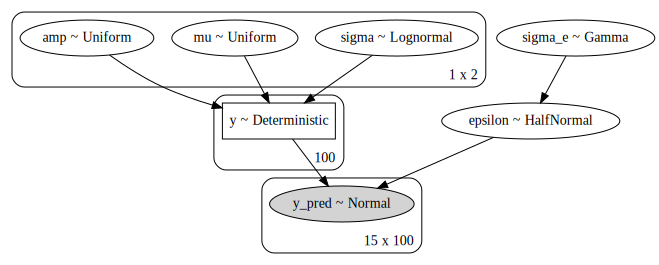

In [11]:
pm.model_to_graphviz(models[0])

In [12]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [13]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 422.85it/s]
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 426.30it/s]


In [18]:
# various plots to inspect the inference results
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
varnames = mdl.get_varnames(traces[0])

#az.plot_trace(traces[2], varnames, combined=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[2], varnames);
#az.plot_posterior(traces[2], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);
az.summary(traces[2], varnames)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",192.385,29.377,180.003,197.280,9.039,6.633,11.0,10.0,57.0,11.0,1.02
"mu[0,1]",317.625,0.010,317.613,317.636,0.001,0.001,118.0,118.0,991.0,105.0,1.01
"mu[0,2]",386.368,0.003,386.363,386.373,0.000,0.000,2124.0,2124.0,2127.0,2031.0,1.00
"sigma[0,0]",2.916,0.889,1.315,4.513,0.027,0.019,1093.0,1093.0,977.0,1043.0,1.00
"sigma[0,1]",2.432,0.007,2.421,2.445,0.000,0.000,175.0,175.0,384.0,111.0,1.01
"sigma[0,2]",2.965,0.002,2.961,2.969,0.000,0.000,2198.0,2198.0,2189.0,2077.0,1.00
epsilon,0.047,0.001,0.046,0.049,0.000,0.000,2068.0,2068.0,2060.0,2166.0,1.00
"amp[0,0]",5.386,3.701,0.000,11.257,0.340,0.241,119.0,119.0,56.0,32.0,1.03
"amp[0,1]",5.004,0.034,4.988,5.031,0.007,0.005,27.0,27.0,163.0,30.0,1.02
"amp[0,2]",12.154,0.006,12.143,12.162,0.000,0.000,2078.0,2077.0,1336.0,1005.0,1.00


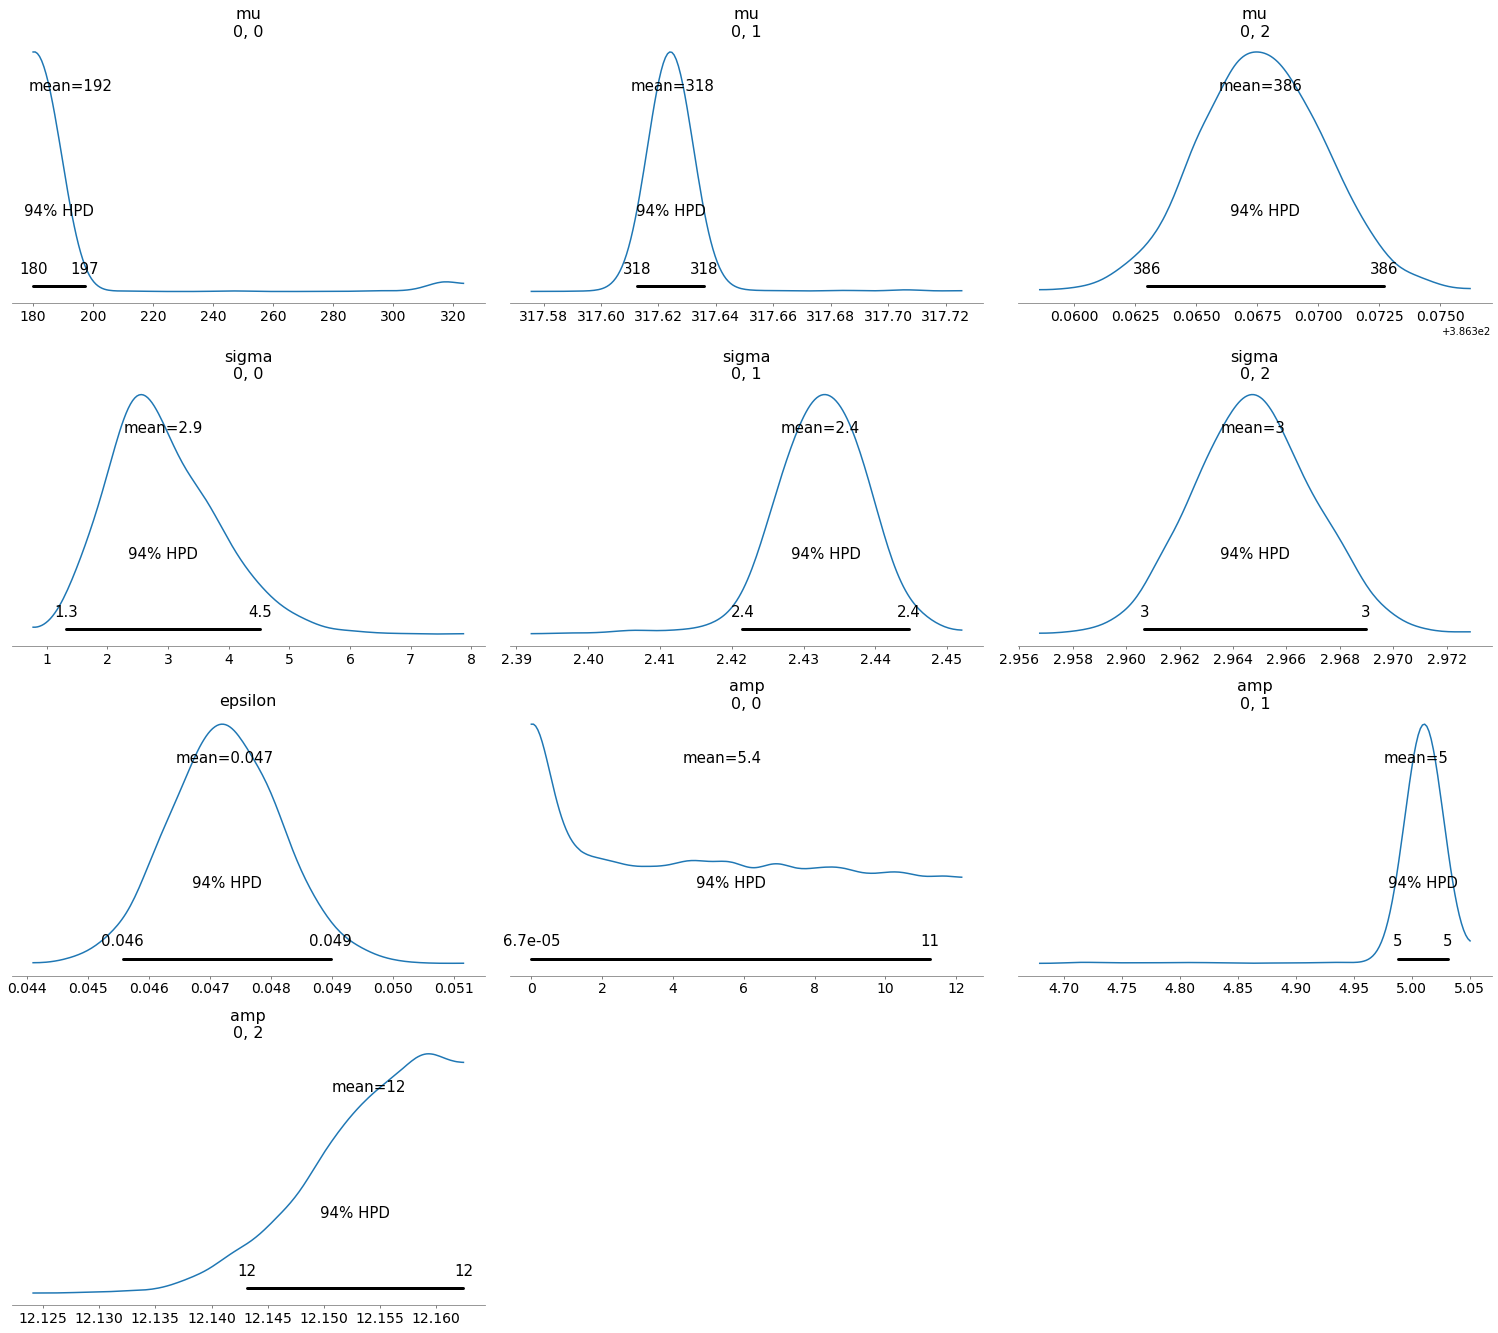

In [15]:
az.plot_posterior(traces[2], varnames);

In [17]:
varnames

['mu', 'sigma', 'epsilon', 'amp']

In [21]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, epsilon_real=0.05, sets=tsets, multimodels='yes', labels=lmodpeak)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
    
    # create list of tuples with model/data combinations
    lm = df['model'].to_list()
    lp = df['data'].to_list()
    lmodpeak = list(zip(lm,lp))
df

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real,model,data
1,1.000,0.000000,4005.857143,1.060614,0.999449,-4893.180502,0.047282,0.05,2,2
2,1.000,0.002714,3522.857143,0.992487,0.846547,6496.115337,2.098843,0.05,2,3
3,1.009,0.941400,1001.100000,0.936176,0.999450,-4892.792697,0.047234,0.05,3,2
4,1.000,0.000100,4190.500000,1.077937,0.999339,-1760.819111,0.133489,0.05,3,3


In [22]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

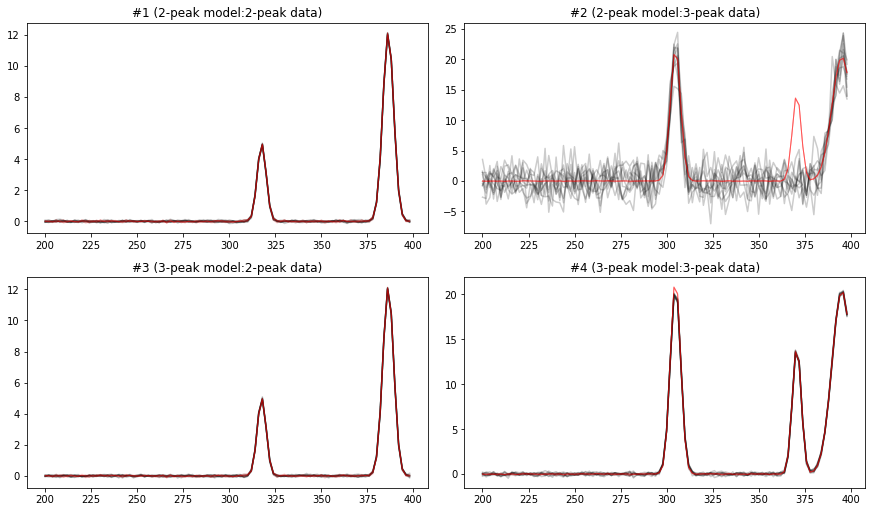

In [23]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
                savefig='yes', fname=file_basename, showpeaks='no', sets=tsets, labels=lmodpeak, scenario='peaks')

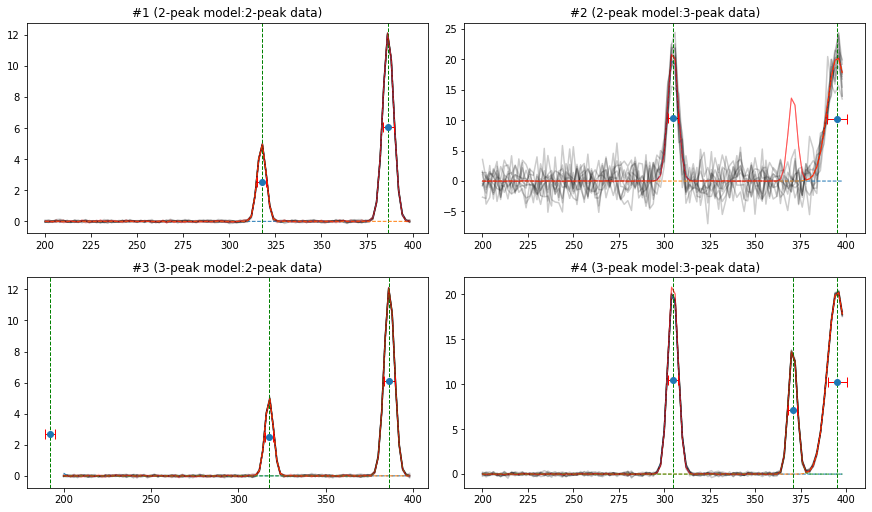

In [34]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
              savefig='yes', fname=file_basename, showpeaks='yes', sets=tsets, labels=lmodpeak, scenario='peaks')

In [25]:
cnf.close(out_path)

## Posterior inspection

In [26]:
# prior predictive samples
ppc_prior = [pm.sample_prior_predictive(samples=500, model=models[i]) for i in range(len(traces))]

In [43]:
traces[2]['y'].shape

(4000, 100)

len trace: 4000
len subsample: 50


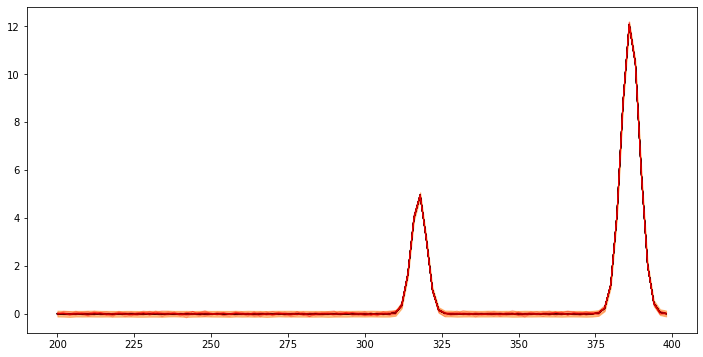

In [72]:
# plot deterministic y component
plt.figure(figsize=(12,6))

xval = [i for i in range(200, 400, 2)]
x_val = np.array(xval, dtype='float32')

# trace
n = 2 

# dataset
ds = 0

l = len(traces[n]['y'])
print("len trace:", l)
a = np.arange(0,l,l/50, dtype=int)
print("len subsample:", len(a))
for i in a:
    y_det = traces[n]['y'][i].flatten()
    plt.plot(x_val, y_det, '-', linewidth=1, color="black", alpha=.25)
    
az.plot_hpd(x_val, ppc[n]['y_pred'], credible_interval=0.99, smooth=False, color= 'C1');

for i in range(15):
    y_val = ldata[ds].values[i]
    plt.plot(x_val, y_val, '-', color="red", alpha=.2, linewidth=1)

len trace: 4000
len subsample: 50


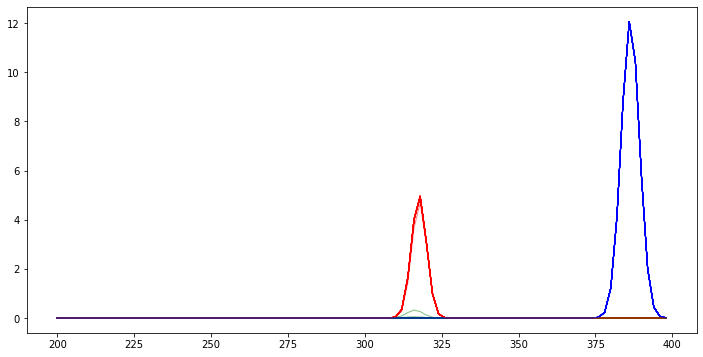

In [33]:
# plot of 3 traces for peaks 1-3 of spectrum #3

plt.figure(figsize=(12,6))

idx = 2 # peak
n = 2 # trace

l = len(traces[n]['mu'])
print("len trace:", l)
a = np.arange(0,l,l/50, dtype=int)
print("len subsample:", len(a))
for i in a:
    A = traces[n]['amp'][i].flatten()
    M = traces[n]['mu'][i].flatten()
    S = traces[n]['sigma'][i].flatten()
    Y0 = A[0] * np.exp(-(x_val - M[0]) ** 2 / (2 * S[0] ** 2))
    plt.plot(x_val, Y0, '-', linewidth=1, color="green", alpha=.5)
    Y1 = A[1] * np.exp(-(x_val - M[1]) ** 2 / (2 * S[1] ** 2))
    plt.plot(x_val, Y1, '-', linewidth=1, color="red", alpha=.5)
    Y2 = A[2] * np.exp(-(x_val - M[2]) ** 2 / (2 * S[2] ** 2))
    plt.plot(x_val, Y2, '-', linewidth=1, color="blue", alpha=.5)

len trace: 4000
len subsample: 50


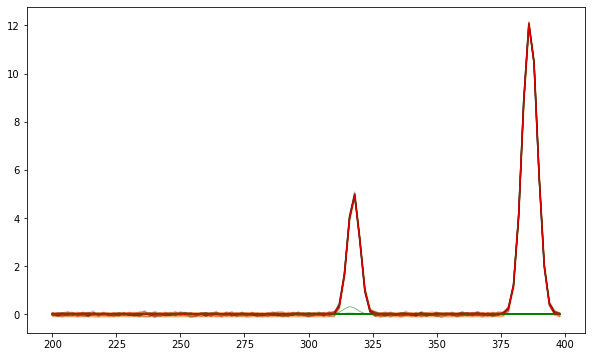

In [37]:
# trace to be plotted
n = 2
label = (3,2)

# dataset
ds = 0

fig.plot_posterior_single(x_val, ldata[ds], traces[n], figure_size=(10,6), savefig='no', fname=file_basename,
                          showpeaks='no', labels=label, samples='yes', posteriors=ppc[n], peakidx=0)

len trace: 4000
len subsample: 50


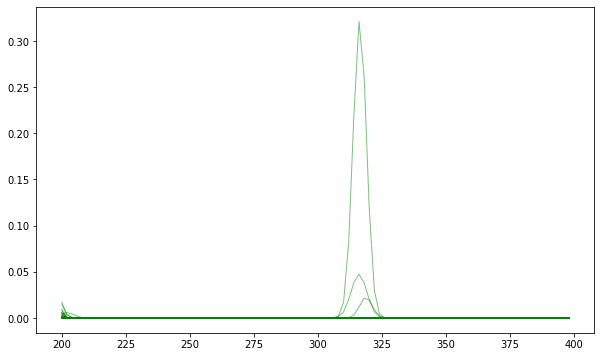

In [38]:
fig.plot_posterior_single(x_val, ldata[ds], traces[n], figure_size=(10,6), savefig='no', fname=file_basename,
                          showpeaks='no', labels=label, peakidx=0)

len trace: 4000
len subsample: 50


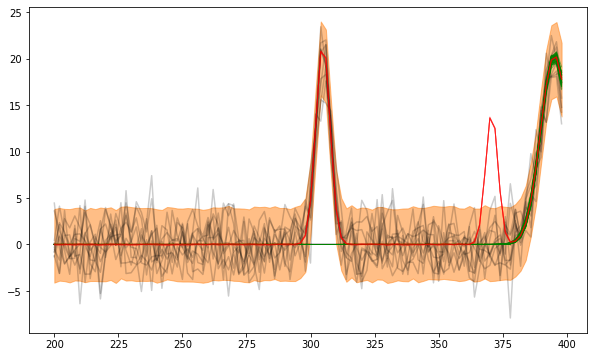

In [39]:
# trace to be plotted
n = 1
label = (2,3)

# dataset
ds = 1

fig.plot_posterior_single(x_val, ldata[ds], traces[n], figure_size=(10,6), savefig='no', fname=file_basename,
                          showpeaks='no', peakidx=1, posteriors=ppc[1], samples='yes')

len mu: 4000


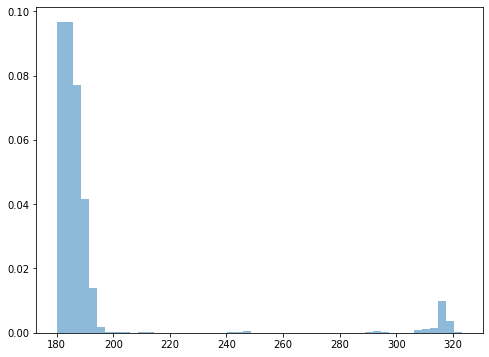

In [31]:
b = []
print("len mu:", len(traces[2]['mu']))
for i in range(len(traces[2]['mu'])):
    b += [traces[2]['mu'][i][0,0]]

plt.figure(figsize=(8,6))
plt.hist(b, bins=50, density=True, alpha=.5);